##  A neural Network replacing the simple xgboost regression algorithm

#### Importing all libraries and setting the device to gpu

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import random

# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

In [2]:
import random
def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU
    
set_seeds()

#### Pre processing the data and adding data indicators to the data

In [3]:
df = pd.read_csv("../../data/reliance/reliance.csv")
# Need to reverse the db
# df = df.loc[::-1]
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True,format="mixed")
df = df[(df['Date'].dt.year >= 2020)].copy()
df.index = range(len(df))
temp = df
# df['Close'] = (df['High'] + df['Low'] )/ 2
df.rename(columns={"Open Price":"Open","High Price":"High","Low Price":"Low","Close Price":"Close","Total Traded Quantity":"Volume","No.of Shares":"Volume","Price":"Close"},inplace=True)
# cols = ["Symbol","Ser verbose=Falseies","Prev Close","Last Price","Average Price","Turnover","No. of Trades", "Deliverable Qty",'% Dly Qt to Traded Qty']
# cols = ["WAP","No. of Trades"	,"Total Turnover (Rs.)"	,"Deliverable Quantity"	,"% Deli. Qty to Traded Qty"	,"Spread High-Low"	,"Spread Close-Open"]
cols = "Adj Close"
# # cols = "Change(%)"
df.drop(columns=cols,inplace=True)   
df.dropna(inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume
0,2020-01-17,1538.912598,1570.067383,1538.615479,1566.154419,13597387
1,2020-01-20,1593.891479,1593.891479,1512.067139,1517.961304,15019904
2,2020-01-21,1514.246460,1531.334473,1507.708374,1519.496704,8732832
3,2020-01-22,1529.501831,1532.226074,1516.723022,1518.951904,4763978
4,2020-01-23,1522.072266,1527.471069,1506.420654,1512.512939,5190829


In [4]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0    
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

df['Close'] = df['Close'].shift(-1)

df = df.iloc[33:] # Because of moving average
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

df.head()

,Date,Open,High,Low,Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2020-03-05,1339.502808,1345.198853,1293.736694,1259.065308,14080540,1394.011439,1330.111865,1382.564661,1408.938005,1428.786536,24.217013,-33.317728,-23.973070
1,2020-03-06,1258.074707,1276.054321,1229.446045,1103.688110,15568253,1384.221844,1315.232886,1363.480554,1398.427629,1421.449414,18.407224,-38.450364,-27.216825
2,2020-03-09,1228.405884,1229.347046,1084.718018,1142.718140,40698294,1371.384861,1303.811157,1342.187390,1385.011467,1413.001160,12.869663,-53.706911,-33.012704
3,2020-03-11,1097.595947,1167.384399,1097.595947,1053.018433,27495503,1343.998209,1263.790503,1309.418005,1360.348576,1399.548674,19.755222,-62.077352,-39.254572
4,2020-03-12,1074.811890,1090.661621,1038.852661,1094.921265,25830369,1323.453649,1226.286011,1283.379822,1338.905168,1387.892493,11.535767,-74.716404,-46.759527


In [5]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High']
df.drop(columns=drop_cols,inplace=True)
df.head()

,Close,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,1259.065308,1394.011439,1330.111865,1382.564661,1408.938005,1428.786536,24.217013,-33.317728,-23.973070
1,1103.688110,1384.221844,1315.232886,1363.480554,1398.427629,1421.449414,18.407224,-38.450364,-27.216825
2,1142.718140,1371.384861,1303.811157,1342.187390,1385.011467,1413.001160,12.869663,-53.706911,-33.012704
3,1053.018433,1343.998209,1263.790503,1309.418005,1360.348576,1399.548674,19.755222,-62.077352,-39.254572
4,1094.921265,1323.453649,1226.286011,1283.379822,1338.905168,1387.892493,11.535767,-74.716404,-46.759527


#### Separating the data into train and test splits. Then splitting into validation split

In [6]:
X = df.iloc[:, 1:]
y = df.iloc[:, 1]

x_len = int(0.8 * len(X))
y_len = int(0.8 * len(y))
X_trainval = X[:x_len]
X_test = X[x_len:]
y_trainval = y[:y_len]
y_test = y[y_len:]

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2
)

#### Normalising the data

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

#### Initialising the dataset

In [8]:
class RegressionDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)   

In [9]:
train_dataset = RegressionDataset(
    torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
)
val_dataset = RegressionDataset(
    torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()
)
test_dataset = RegressionDataset(
    torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
)

#### Setting hyper parameters

In [10]:
EPOCHS = 850
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)

In [11]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [12]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()

        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return x

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return x
# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

In [13]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=8, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [14]:
loss_stats = {
    'train': [],
    "val": []
}

In [15]:
for e in tqdm(range(1, EPOCHS + 1)):
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(
            device
        )
        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)

        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))

        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()

    # VALIDATION
    with torch.no_grad():
        val_epoch_loss = 0

        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)

            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))

            val_epoch_loss += val_loss.item()
        # print(torch.cuda.get_device_name())

        loss_stats["train"].append(train_epoch_loss / len(train_loader))
        loss_stats["val"].append(val_epoch_loss / len(val_loader))

    if e % 50 == 0:
        print(
            f"Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}"
        )
# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

  0%|          | 0/850 [00:00<?, ?it/s]

  8%|▊         | 70/850 [00:05<00:19, 40.09it/s] 

Epoch 050: | Train Loss: 35239.86306 | Val Loss: 42390.08529


 15%|█▍        | 124/850 [00:05<00:08, 90.62it/s]

Epoch 100: | Train Loss: 29263.92795 | Val Loss: 37332.81706


 19%|█▉        | 165/850 [00:06<00:05, 115.29it/s]

Epoch 150: | Train Loss: 23670.63173 | Val Loss: 30985.17318


 26%|██▌       | 222/850 [00:06<00:04, 127.67it/s]

Epoch 200: | Train Loss: 17911.02995 | Val Loss: 24755.18945


 31%|███       | 264/850 [00:06<00:04, 133.10it/s]

Epoch 250: | Train Loss: 13268.75873 | Val Loss: 18969.15885


 38%|███▊      | 321/850 [00:07<00:03, 138.16it/s]

Epoch 300: | Train Loss: 9866.47021 | Val Loss: 13741.65690


 44%|████▍     | 377/850 [00:07<00:03, 133.83it/s]

Epoch 350: | Train Loss: 6500.26232 | Val Loss: 9027.56868


 49%|████▉     | 419/850 [00:07<00:03, 133.96it/s]

Epoch 400: | Train Loss: 3701.79272 | Val Loss: 5102.03638


 56%|█████▌    | 474/850 [00:08<00:03, 123.17it/s]

Epoch 450: | Train Loss: 1712.44859 | Val Loss: 2311.93315


 61%|██████    | 515/850 [00:08<00:02, 129.52it/s]

Epoch 500: | Train Loss: 553.31328 | Val Loss: 767.23362


 67%|██████▋   | 571/850 [00:09<00:02, 132.20it/s]

Epoch 550: | Train Loss: 125.39882 | Val Loss: 175.95173


 74%|███████▍  | 627/850 [00:09<00:01, 131.60it/s]

Epoch 600: | Train Loss: 23.62396 | Val Loss: 33.28959


 79%|███████▊  | 669/850 [00:09<00:01, 134.83it/s]

Epoch 650: | Train Loss: 8.16570 | Val Loss: 10.68488


 85%|████████▌ | 726/850 [00:10<00:00, 133.98it/s]

Epoch 700: | Train Loss: 6.35674 | Val Loss: 7.93555


 90%|█████████ | 768/850 [00:10<00:00, 129.83it/s]

Epoch 750: | Train Loss: 6.06970 | Val Loss: 7.72984


 97%|█████████▋| 824/850 [00:11<00:00, 125.19it/s]

Epoch 800: | Train Loss: 6.18213 | Val Loss: 7.69344


100%|██████████| 850/850 [00:11<00:00, 75.04it/s] 

Epoch 850: | Train Loss: 5.98419 | Val Loss: 7.62880


In [16]:
print(len(loss_stats['train']))
print(len(loss_stats['val']))

850
850


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

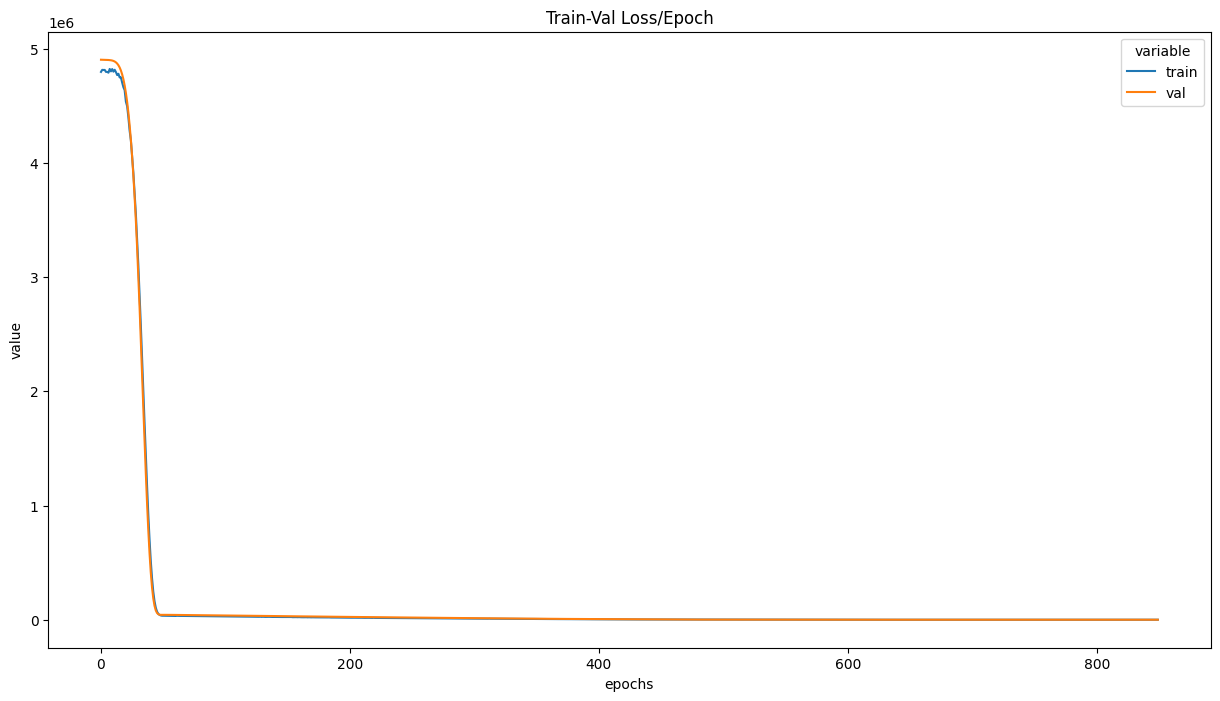

In [17]:
train_val_loss_df = (
    pd.DataFrame.from_dict(loss_stats)
    .reset_index()
    .melt(id_vars=["index"])
    .rename(columns={"index": "epochs"})
)
plt.figure(figsize=(15, 8))
sns.lineplot(data=train_val_loss_df, x="epochs", y="value", hue="variable").set_title(
    "Train-Val Loss/Epoch"
)

100%|██████████| 3/3 [00:00<00:00, 20763.88it/s]

[2641.3992, 2642.5203, 2643.4558, 2640.5273, 2637.741, 2635.9604, 2634.9382, 2631.2864, 2625.239, 2622.1003, 2620.2322, 2615.5015, 2611.5105, 2601.368, 2592.8953, 2586.0464, 2580.939, 2576.967, 2576.5654, 2577.8855, 2575.6829, 2570.847, 2566.708, 2565.5845, 2567.381, 2565.386, 2561.3472, 2553.4998, 2546.001, 2533.592, 2526.2437, 2520.6987, 2517.1807, 2510.4246, 2501.7888, 2491.9924, 2480.9014, 2467.8147, 2457.1848, 2445.8894, 2433.5344, 2422.3586, 2413.8406, 2405.3743, 2395.3835, 2390.7415, 2387.3162, 2382.8901, 2377.1775, 2376.9841, 2380.7917, 2385.7986, 2392.7441, 2396.7874, 2401.1216, 2397.9114, 2393.9321, 2392.444, 2391.5564, 2384.4783, 2379.5354, 2373.307, 2373.18, 2376.61, 2380.63, 2378.6033, 2374.0461, 2364.6174, 2353.9197, 2340.4824, 2329.1426, 2319.3625, 2307.2012, 2302.9014, 2300.6072, 2296.9963, 2289.596, 2286.3577, 2281.4265, 2274.779, 2279.108, 2285.357, 2290.0784, 2295.2908, 2299.4265, 2302.3499, 2307.881, 2313.4165, 2318.1604, 2320.6477, 2323.5862, 2326.1414, 2327.4128, 

[Text(0.5, 1.0, 'Deviation of Error')]

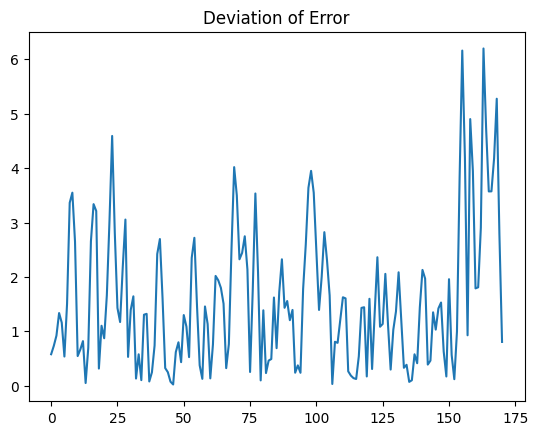

In [18]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
        y_pred_list = [a for a in y_pred_list]
        
y_pred = []
for i in tqdm(range(len(y_pred_list))):
    for j in range(len(y_pred_list[i])):
        for k in range(len(y_pred_list[i][j])):
            y_pred.append(y_pred_list[i][j][k])

print(y_pred)  
print(y_test.tolist())
y_pred_np = np.array(y_pred)
difference = np.subtract(y_pred_np, y_test)
difference = abs(difference)
mean_difference = np.mean(difference)
print(f"The average deviation in error is: {mean_difference}")
sns.lineplot(difference).set(title="Deviation of Error")

In [19]:
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
mean_abs_err = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)
print(f"Accuracy (using MSE): {(100 - mse)}%")
print(f"Mean absolute percentage error: {100 - mean_abs_err}%")

Mean Squared Error : 4.099612569693101
R^2 : 0.9996652431106676
Accuracy (using MSE): 95.90038743030689%
Mean absolute percentage error: 99.99936870469018%


#### Visualising the data

In [20]:
import plotly as py
import plotly.io as pio    
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [21]:
test_vals = temp.index[x_len:]
fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(x=temp.index, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple'), row=2, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=3, col=1)

# )


fig.show()